This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2024.1_tutorials/wallaroo-observe/houseprice-saga).

## House Price Testing Life Cycle Succinct Version

This tutorial simulates using Wallaroo for testing a model for inference outliers, potential model drift, and methods to test competitive models against each other and deploy the final version to use.  This demonstrates using assays to detect model or data drift, then Wallaroo Shadow Deploy to compare different models to determine which one is most fit for an organization's needs.  These features allow organizations to monitor model performance and accuracy then swap out models as needed.

* **IMPORTANT NOTE**: This tutorial assumes that the House Price Model Life Cycle Preparation notebook was run before this notebook, and that the workspace, pipeline and models used are the same.  This is **critical** for the section on Assays below.  If the preparation notebook has not been run, skip the Assays section as there will be no historical data for the assays to function on.

This tutorial will demonstrate how to:

1. Select or create a workspace, pipeline and upload the champion model.
1. Add a pipeline step with the champion model, then deploy the pipeline and perform sample inferences.
1. Create an assay and set a baseline, then demonstrate inferences that trigger the assay alert threshold.
    1. This process will use an existing assay to demonstrate the 
1. Swap out the pipeline step with the champion model with a shadow deploy step that compares the champion model against two competitors.
1. Evaluate the results of the champion versus competitor models.
1. Swap out the existing model with a competitor without undeploying the pipeline.  This allows the pipeline to continue to receive inference requests while swapping the model.
1. Undeploy the pipeline at the end of the tutorial.

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

## Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame

## Initial Steps

### Import libraries

The first step is to import the libraries needed for this notebook.

In [1]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import datetime
import time


### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [2]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

### Retrieve the Workspace

For our example, the workspace, pipeline and model have already been created in the Wallaroo instance.  We will retrieve these and store them to local variables for our examples.



We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [3]:
workspace_name = f'housepricesagaworkspacebaseline-examples'
main_pipeline_name = f'housepricesagapipeline'
model_name_control = f'housepricesagacontrol'
model_file_name_control = './models/rf_model.onnx'

In [5]:
workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)

wl.set_current_workspace(workspace)

{'name': 'housepricesagaworkspacebaseline-examples', 'id': 86, 'archived': False, 'created_by': 'd6a42dd8-1da9-4405-bb80-7c4b42e38b52', 'created_at': '2023-10-31T16:29:48.848568+00:00', 'models': [{'name': 'housepricesagacontrol', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2023, 10, 31, 16, 29, 49, 151343, tzinfo=tzutc()), 'created_at': datetime.datetime(2023, 10, 31, 16, 29, 49, 151343, tzinfo=tzutc())}], 'pipelines': [{'name': 'housepricesagapipeline', 'create_time': datetime.datetime(2023, 10, 31, 16, 29, 49, 230421, tzinfo=tzutc()), 'definition': '[]'}]}

### Upload The Champion Model

For our example, we will retrieve the previously uploaded champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

In [6]:
housing_model_control = wl.get_model(model_name_control)
housing_model_control

Name,housepricesagacontrol
Version,f700b294-6b5c-4faf-92d8-401c9bf56b03
File Name,rf_model.onnx
SHA,e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6
Status,ready
Image Path,None
Architecture,None
Updated At,2023-31-Oct 16:29:49


## Standard Pipeline Steps

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step, with a single validation.

Anomaly detection allows organizations to set validation parameters in a pipeline. A validation is added to a pipeline to test data based on an expression, and flag any inferences where the validation failed inference result and the pipeline logs.

Validations are added through the Pipeline `add_validation(name, validation)` command which uses the following parameters:

| Parameter | Type | Description |
|---|---|---|
| name | String (**Required**) | The name of the validation. |
| Validation | [Expression](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/checks/#Expression) (**Required**) | The validation test command in the format `model_name.outputs][field][index] {Operation} {Value}`. |

For this example, we want to detect the outputs of `housing_model_control` and validate that values are less than `1,500,000`.  Any outputs greater than that will trigger a `check_failure` which is shown in the output.

In [25]:
mainpipeline = wl.get_pipeline(main_pipeline_name)

# removes any previous steps
mainpipeline.undeploy()
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

mainpipeline = mainpipeline.add_validation('price too high', housing_model_control.outputs[0][0] < 1500000.0)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()
mainpipeline.deploy(deployment_config = deploy_config)

Waiting for undeployment - this will take up to 45s ..................................... ok
Waiting for deployment - this will take up to 45s .............. ok


name,housepricesagapipeline
created,2023-10-31 16:29:49.230421+00:00
last_updated,2023-10-31 16:47:28.679255+00:00
deployed,True
tags,
versions,"13704ba7-fac9-4055-8930-d8ed9a66909c, ba5748ac-8225-47e3-9842-e8f49b658c58, aeff29b2-69b3-4ee2-b501-c97e085ed893, 8e6a0e06-e415-43ab-85c1-76560e0f5aff, d72af4cf-de94-417a-8cb2-abc6b3ff4ceb, c834a1ad-b574-47e2-902b-db8a3466494a, 4500760b-00be-48a4-aff1-89079664e203, 097caab6-9087-4e6b-a936-667ff1ebdb02"
steps,housepricesagacontrol
published,False


### Validation Testing

Two validations will be tested:

* One that should return a house value lower than 1,500,000.  The validation will pass so `check_failure` will be 0.
* The other than should return a house value greater than 1,500,000.  The validation will fail, so `check_failure` will be 1.

In [26]:
# Small value home

normal_input = pd.DataFrame.from_records({
        "tensor": [[
            3.0,
            2.25,
            1620.0,
            997.0,
            2.5,
            0.0,
            0.0,
            3.0,
            8.0,
            1540.0,
            80.0,
            47.5400009155,
            -122.0260009766,
            1620.0,
            1068.0,
            4.0,
            0.0,
            0.0
        ]]
    }
)

small_result = mainpipeline.infer(normal_input)

display(small_result.loc[:,["time", "out.variable", "check_failures"]])

,time,out.variable,check_failures
0,2023-10-31 16:47:49.877,[544392.06],0


In [27]:
# Big value home

big_input = pd.DataFrame.from_records({
        "tensor": [[
            4.0,
            4.5,
            5770.0,
            10050.0,
            1.0,
            0.0,
            3.0,
            5.0,
            9.0,
            3160.0,
            2610.0,
            47.6769981384,
            -122.2750015259,
            2950.0,
            6700.0,
            65.0,
            0.0,
            0.0
        ]]
    }
)

big_result = mainpipeline.infer(big_input)

display(big_result.loc[:,["time", "out.variable", "check_failures"]])

,time,out.variable,check_failures
0,2023-10-31 16:47:50.081,[1689843.1],1


### Anomaly Results

We'll run through our previous batch, this time showing only those results outside of the validation, and a graph showing where the anomalies are against the other results.

This time we will be using an Apache Arrow table to submit 1000 inferences in a single batch.

In [28]:
batch_inferences = mainpipeline.infer_from_file('./data/xtest-1k.arrow')

large_inference_result =  batch_inferences.to_pandas()

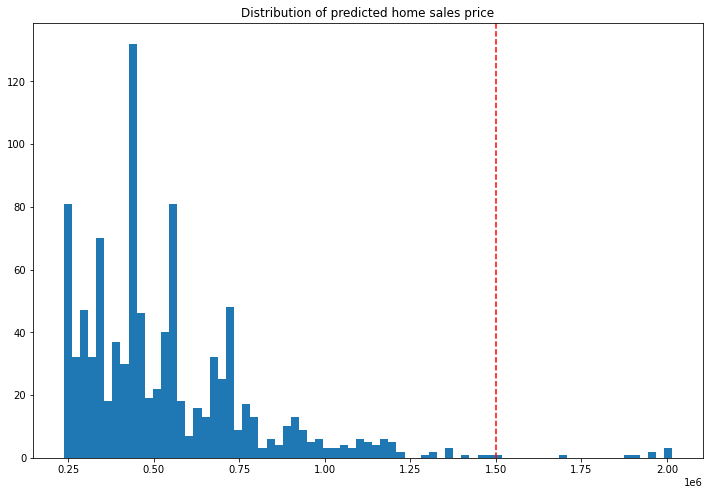

In [29]:
import matplotlib.pyplot as plt
houseprices = pd.DataFrame({'sell_price': large_inference_result['out.variable'].apply(lambda x: x[0])})

houseprices.hist(column='sell_price', bins=75, grid=False, figsize=(12,8))
plt.axvline(x=1500000, color='red', ls='--')
_ = plt.title('Distribution of predicted home sales price')

## Shadow Deploy

Let's assume that after analyzing the assay information we want to test two challenger models to our control.  We do that with the Shadow Deploy pipeline step.

In Shadow Deploy, the pipeline step is added with the `add_shadow_deploy` method, with the champion model listed first, then an array of challenger models after.  **All** inference data is fed to **all** models, with the champion results displayed in the `out.variable` column, and the shadow results in the format `out_{model name}.variable`.  For example, since we named our challenger models `housingchallenger01` and `housingchallenger02`, the columns `out_housingchallenger01.variable` and `out_housingchallenger02.variable` have the shadow deployed model results.

For this example, we will remove the previous pipeline step, then replace it with a shadow deploy step with `rf_model.onnx` as our champion, and models `xgb_model.onnx` and `gbr_model.onnx` as the challengers.  We'll deploy the pipeline and prepare it for sample inferences.

In [30]:
# Upload the challenger models

model_name_challenger01 = 'housingchallenger01'
model_file_name_challenger01 = './models/xgb_model.onnx'

model_name_challenger02 = 'housingchallenger02'
model_file_name_challenger02 = './models/gbr_model.onnx'

housing_model_challenger01 = (wl.upload_model(model_name_challenger01, 
                                              model_file_name_challenger01, 
                                              framework=Framework.ONNX)
                                              .configure(tensor_fields=["tensor"])
                            )
housing_model_challenger02 = (wl.upload_model(model_name_challenger02, 
                                              model_file_name_challenger02, 
                                              framework=Framework.ONNX)
                                              .configure(tensor_fields=["tensor"])
                            )


In [31]:
# Add the new shadow deploy step with our challenger models
mainpipeline.replace_with_shadow_deploy(0, housing_model_control, [housing_model_challenger01, housing_model_challenger02])

# Deploy the pipeline with the new shadow step
#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()
mainpipeline.deploy(deployment_config = deploy_config)

 ok


name,housepricesagapipeline
created,2023-10-31 16:29:49.230421+00:00
last_updated,2023-10-31 16:47:54.645371+00:00
deployed,True
tags,
versions,"7b0de2c4-3feb-4c2f-a26f-37c1e9d38dbc, 13704ba7-fac9-4055-8930-d8ed9a66909c, ba5748ac-8225-47e3-9842-e8f49b658c58, aeff29b2-69b3-4ee2-b501-c97e085ed893, 8e6a0e06-e415-43ab-85c1-76560e0f5aff, d72af4cf-de94-417a-8cb2-abc6b3ff4ceb, c834a1ad-b574-47e2-902b-db8a3466494a, 4500760b-00be-48a4-aff1-89079664e203, 097caab6-9087-4e6b-a936-667ff1ebdb02"
steps,housepricesagacontrol
published,False


### Shadow Deploy Comparison

We can now perform a comparison between the different model results in one graph.

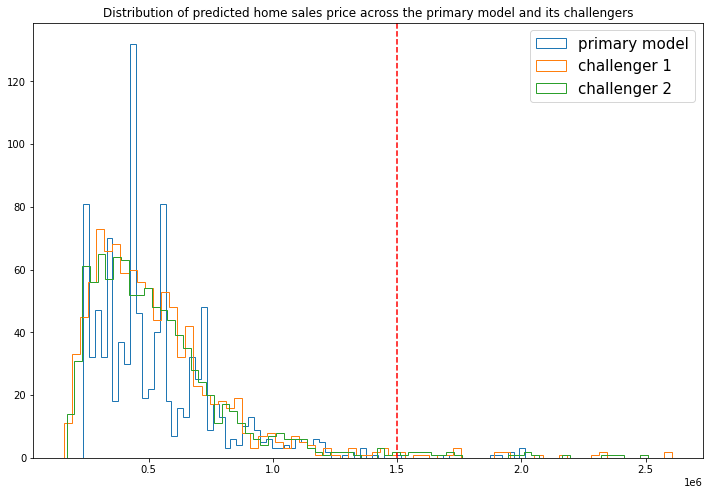

In [33]:
shadow_result = mainpipeline.infer_from_file('./data/xtest-1k.arrow')

shadow_outputs =  shadow_result.to_pandas()

import matplotlib.pyplot as plt
d=houseprices_primary = pd.DataFrame({'sell_price': shadow_outputs['out.variable'].apply(lambda x: x[0])})
d1=houseprices_challenger1 = pd.DataFrame({'sell_price': shadow_outputs['out_housingchallenger01.variable'].apply(lambda x: x[0])})
d2=houseprices_challenger2 = pd.DataFrame({'sell_price': shadow_outputs['out_housingchallenger02.variable'].apply(lambda x: x[0])})
plt.figure(figsize=(12,8))
plt.hist(d, bins=75, histtype="step", label="primary model")
plt.hist(d1 , bins=75, histtype="step", label="challenger 1")
plt.hist(d2 , bins=75, histtype="step", label="challenger 2")
plt.axvline(x=1500000.0, color='red', ls='--')
plt.legend(prop={'size': 15})
_ = plt.title('Distribution of predicted home sales price across the primary model and its challengers')
plt.show()

## Model Swap

Now that we've completed our testing, we can swap our deployed model in the original `housepricingpipeline` with one we feel works better.

We'll start by **removing** the A/B Testing pipeline step, then going back to a **single pipeline step with the champion model** and perform a test inference.

When going from a testing step such as A/B Testing or Shadow Deploy, it is best to undeploy the pipeline, change the steps, then deploy the pipeline.  In a production environment, there should be two pipelines:  One for production, the other for testing models.  Since this example uses one pipeline for simplicity, we will undeploy our main pipeline and reset it back to a one-step pipeline with the current champion model as our pipeline step.

Once done, we'll perform the hot swap with the model `gbr_model.onnx`, which was labeled `housing_model_challenger02` in a previous step.  We'll do an inference with the same data as used with the challenger model.  Note that previously, the inference through the original model returned `[718013.7]`.

In [35]:
mainpipeline.undeploy()

# remove the shadow deploy steps
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()
mainpipeline.deploy(deployment_config = deploy_config)

# Inference test
normal_input = pd.DataFrame.from_records({"tensor": [[4.0,
            2.25,
            2200.0,
            11250.0,
            1.5,
            0.0,
            0.0,
            5.0,
            7.0,
            1300.0,
            900.0,
            47.6845,
            -122.201,
            2320.0,
            10814.0,
            94.0,
            0.0,
            0.0]]})
controlresult = mainpipeline.infer(normal_input)
display(controlresult)

Waiting for undeployment - this will take up to 45s ........ ok
Waiting for deployment - this will take up to 45s ......... ok


,time,in.tensor,out.variable,check_failures
0,2023-10-31 16:49:36.321,"[4.0, 2.25, 2200.0, 11250.0, 1.5, 0.0, 0.0, 5.0, 7.0, 1300.0, 900.0, 47.6845, -122.201, 2320.0, 10814.0, 94.0, 0.0, 0.0]",[682284.56],0


Now we'll "hot swap" the control model.  We don't have to undeploy the pipeline - we can just swap the model out in that pipeline step and continue with only a millisecond or two lost while the swap was performed.

In [37]:
# Perform hot swap

mainpipeline.replace_with_model_step(0, housing_model_challenger02).deploy()
# wait for the swap to complete
import time
time.sleep(15)

# inference after model swap
normal_input = pd.DataFrame.from_records({"tensor": [[4.0,
            2.25,
            2200.0,
            11250.0,
            1.5,
            0.0,
            0.0,
            5.0,
            7.0,
            1300.0,
            900.0,
            47.6845,
            -122.201,
            2320.0,
            10814.0,
            94.0,
            0.0,
            0.0]]})
challengerresult = mainpipeline.infer(normal_input)
display(challengerresult)

 ok


,time,in.tensor,out.variable,check_failures
0,2023-10-31 16:50:17.942,"[4.0, 2.25, 2200.0, 11250.0, 1.5, 0.0, 0.0, 5.0, 7.0, 1300.0, 900.0, 47.6845, -122.201, 2320.0, 10814.0, 94.0, 0.0, 0.0]",[770916.6],0


In [38]:
# Display the difference between the two

display(f'Original model output: {controlresult.loc[0]["out.variable"]}')
display(f'Hot swapped model  output: {challengerresult.loc[0]["out.variable"]}')

'Original model output: [682284.56]'

'Hot swapped model  output: [770916.6]'

### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [39]:
mainpipeline.undeploy()

Waiting for undeployment - this will take up to 45s ..................................... ok


name,housepricesagapipeline
created,2023-10-31 16:29:49.230421+00:00
last_updated,2023-10-31 16:50:02.677896+00:00
deployed,False
tags,
versions,"84be01ce-5869-4fdd-af45-8db6b8bf3ef8, 87a06ff0-f235-434e-a6d8-e49c51e63339, 427ec384-f689-4f72-be54-04b7577f7ba7, 7b0de2c4-3feb-4c2f-a26f-37c1e9d38dbc, 13704ba7-fac9-4055-8930-d8ed9a66909c, ba5748ac-8225-47e3-9842-e8f49b658c58, aeff29b2-69b3-4ee2-b501-c97e085ed893, 8e6a0e06-e415-43ab-85c1-76560e0f5aff, d72af4cf-de94-417a-8cb2-abc6b3ff4ceb, c834a1ad-b574-47e2-902b-db8a3466494a, 4500760b-00be-48a4-aff1-89079664e203, 097caab6-9087-4e6b-a936-667ff1ebdb02"
steps,housepricesagacontrol
published,False
